In [6]:
import numpy as np
import matplotlib.pyplot as plt



import sys
import os
BASE_PATH = './../../dynaphos-core/'
sys.path.append(BASE_PATH)

from dynaphos import utils
from dynaphos.cortex_models import get_visual_field_coordinates_from_cortex, Map
from dynaphos.image_processing import canny_processor, sobel_processor
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator
from dynaphos.utils import get_data_kwargs, to_numpy
from dynaphos import cortex_models

import torch

from matplotlib_scalebar.scalebar import ScaleBar

In [7]:
# Load colorstyles 
plt.style.use('../_figurestyle/small.mplstyle')
COLORSTYLE = utils.load_params('../_figurestyle/colors.yaml')

LINE_COLOR = COLORSTYLE['red'][1]
BOUNDS_COLOR = COLORSTYLE['turquoise'][2]

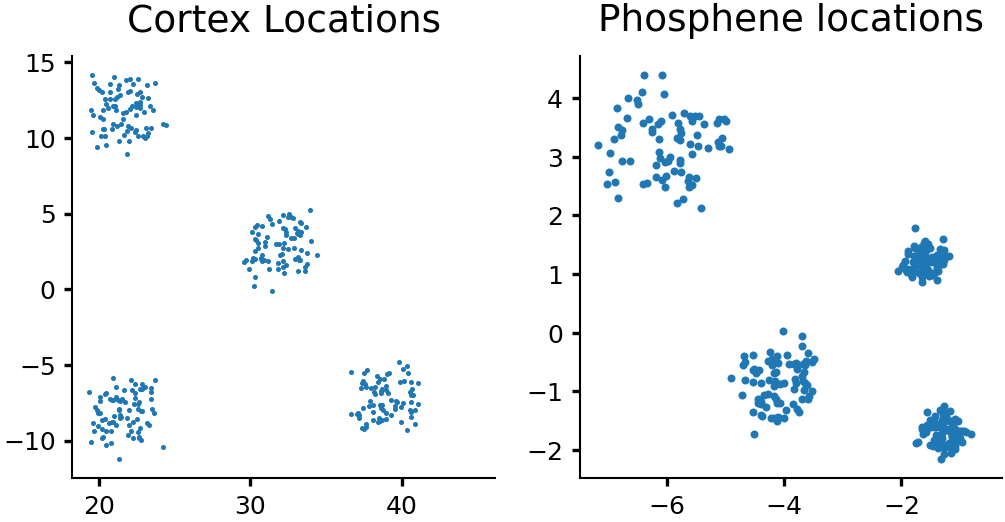

In [80]:
PLOT_TRUE_CORTEX_LOCATIONS = True # set true for plotting the distorted cortex locations corresponding to the phosphenes. 


# read parameters from yaml file
params = utils.load_params(os.path.join(BASE_PATH, 'config','params.yaml'))

utils.load_coordinates_from_yaml('test.yaml')

# initialise phopshene locations, either using a cortex model or semi-probabilistically
# x,y = utils.load_coordinates_from_yaml(os.path.join(BASE_PATH, 'config', 'grid_coords_squares.yaml'))
x,y = utils.load_coordinates_from_yaml('test.yaml')
coordinates_cortex = Map(x,y)
coordinates_visual_field = get_visual_field_coordinates_from_cortex(params['cortex_model'], coordinates_cortex)

if PLOT_TRUE_CORTEX_LOCATIONS:
    # plot electrode locations (convert back from phosphene locataions to capture the added dropout and noise)
    visual_field_to_cortex = cortex_models.get_mapping_from_visual_field_to_cortex(params['cortex_model'])
    z = coordinates_visual_field.flip(hor=True, vert=True).complex
    coordinates_cortex = Map(z=visual_field_to_cortex(z))

    
# Plot cortex locations
fig, axs = plt.subplots(1,2, figsize=(4,2))
axs[0].scatter(*coordinates_cortex.cartesian, marker= '.', s=2)
axs[0].axis('square')
axs[0].set_title('Cortex Locations')


# plot phosphene locations
r, phi = coordinates_visual_field.polar
axs[1].scatter(r*np.cos(phi),r*np.sin(phi), s=2)
axs[1].axis('square')
axs[1].set_title('Phosphene locations')
plt.show()

# initialise simulator
simulator = PhospheneSimulator(params, coordinates_visual_field)
N_PHOSPHENES = simulator.num_phosphenes

data_kwargs = get_data_kwargs(params)
device = data_kwargs['device']

RESOLUTION = params['run']['resolution']

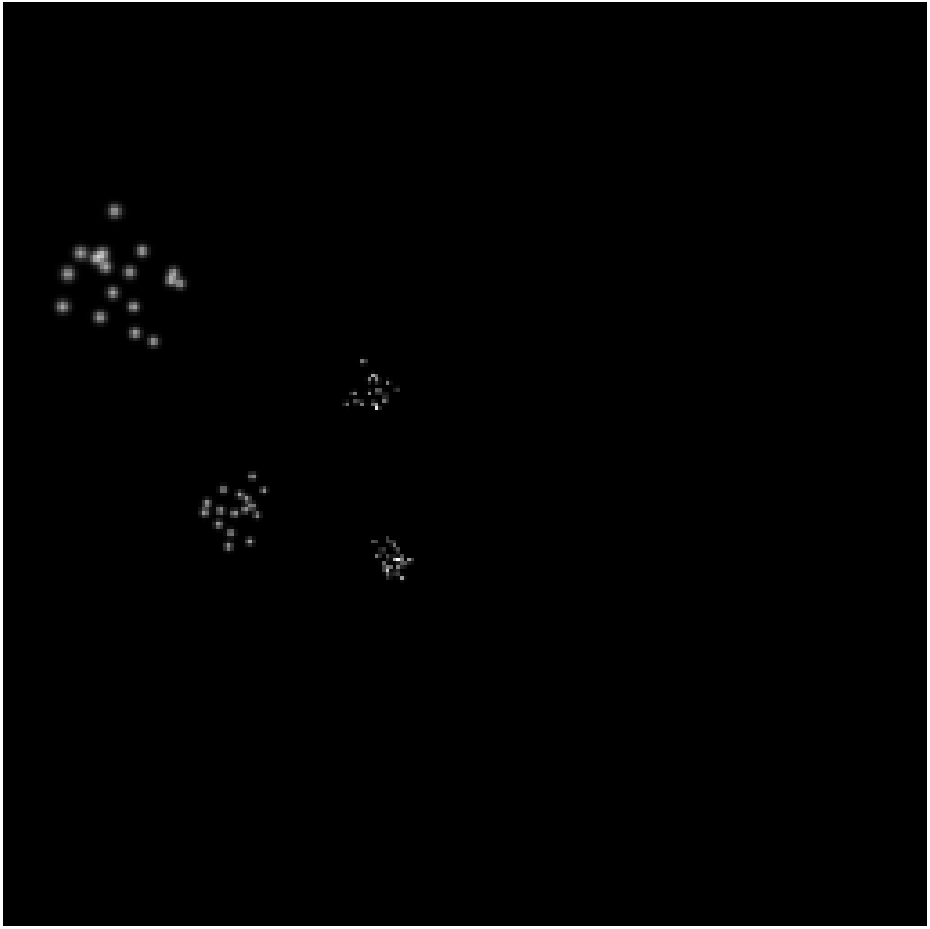

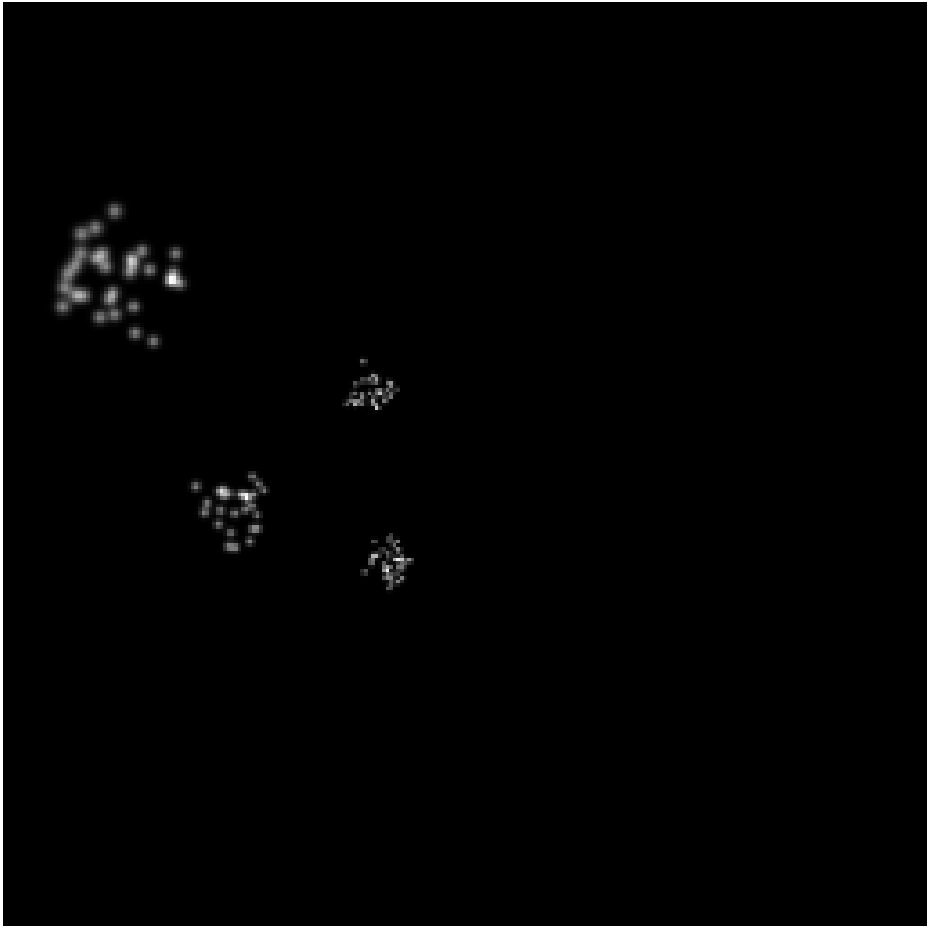

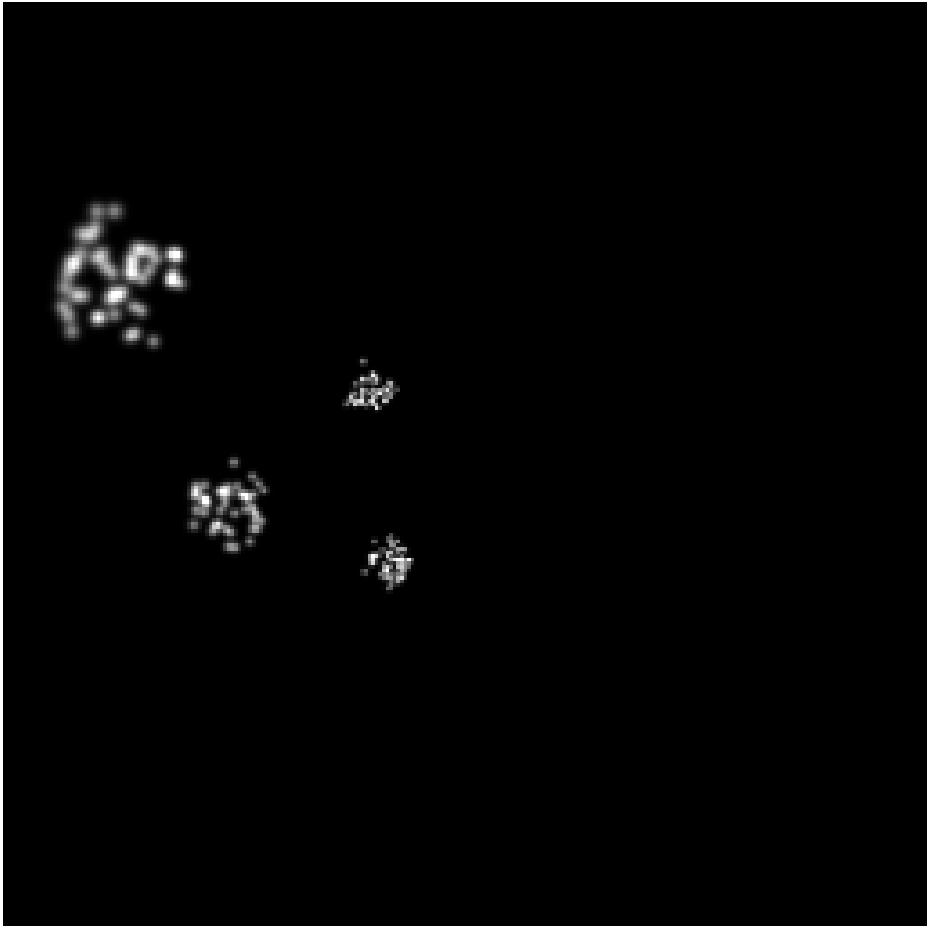

In [81]:
# initialise simulator
simulator = PhospheneSimulator(params, coordinates_visual_field)
N_PHOSPHENES = simulator.num_phosphenes

data_kwargs = get_data_kwargs(params)
device = data_kwargs['device']

RESOLUTION = params['run']['resolution']

# plot phosphenes for different input strengths
stims = np.array([60.,80.,100.])*1e-6

imgs = []
for i,stim in enumerate(stims):

    simulator.reset()
    stim_pattern = stim*torch.ones(N_PHOSPHENES,device=device)
    img = to_numpy(simulator(stim_pattern)).clip(max=1)
    imgs.append(img)

    plt.imshow(img,cmap='gray',origin='lower')
    plt.axis('off')
    plt.show()

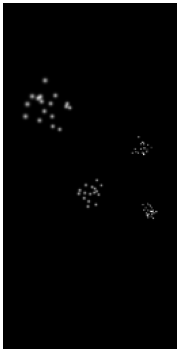

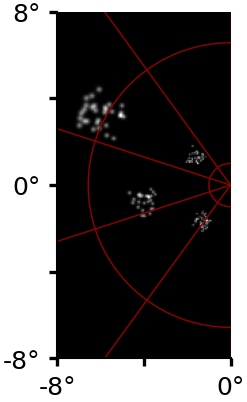

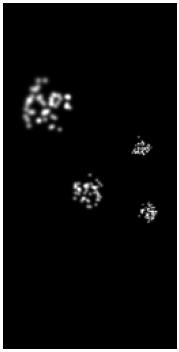

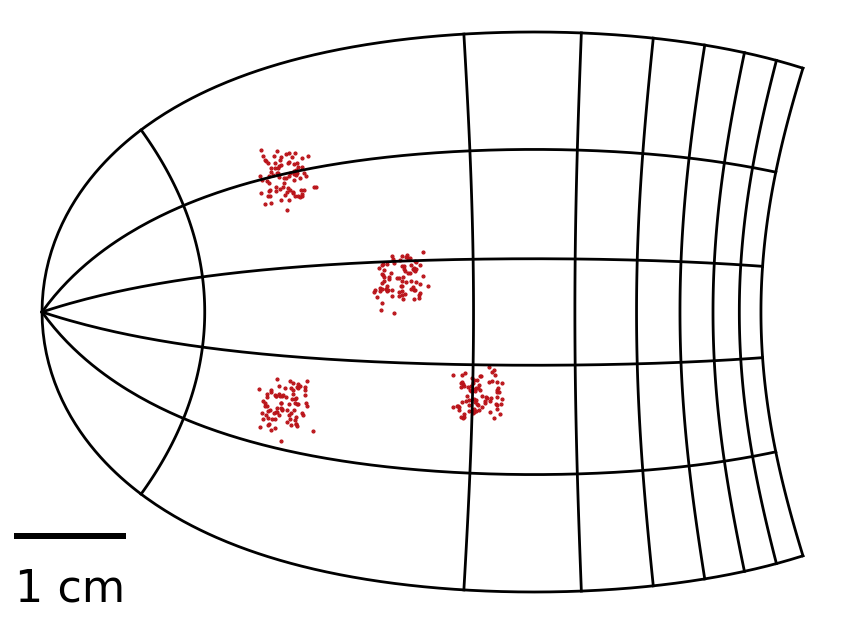

In [82]:
# Mapping from visual field to cortex (for creating the cortex model grid)
visual_field_to_cortex = cortex_models.get_mapping_from_visual_field_to_cortex(params['cortex_model'])

# Initialize figures
# fig, axs = plt.subplots(1,3, figsize=(3,1.5), dpi=300)

_, ax_0 = plt.subplots(1,1, figsize=(1,1.5), dpi=300)
_, ax_1 = plt.subplots(1,1, figsize=(1,1.5), dpi=300) 
_, ax_2 = plt.subplots(1,1, figsize=(1,1.5), dpi=300)

_, ax_3 = plt.subplots(1,1, figsize=(2.7,2), dpi=400)

axs = [ax_0, ax_1, ax_2, ax_3] 

# Plot the radial grid lines    
for angle in np.linspace(.5*np.pi,1.5*np.pi,6) :
    r = []
    phi = []
    for radius in np.linspace(0,40,1000):
        r.append(radius)
        phi.append(angle)
    
    visual_field = Map(r = np.array(r), phi = np.array(phi))
    ax_1.plot(*visual_field.cartesian,linewidth=.35, color=COLORSTYLE['red'][0])
    
    w = visual_field.flip(hor=True, vert=True).complex
    cortex = Map(z=visual_field_to_cortex(w))
    ax_3.plot(*cortex.cartesian, 'k',linewidth=.5)
    
    
# Plot the concentric grid lines
for radius in np.linspace(1,40,8):
    r = []
    phi = []
    for angle in np.linspace(.5*np.pi,1.5*np.pi,100):
        r.append(radius)
        phi.append(angle)
    
    visual_field = Map(r = np.array(r), phi = np.array(phi))
    ax_1.plot(*visual_field.cartesian,linewidth=.35, color=COLORSTYLE['red'][0])
    
    w = visual_field.flip(hor=True, vert=True).complex
    cortex = Map(z=visual_field_to_cortex(w))
    ax_3.plot(*cortex.cartesian, 'k',linewidth=.5)


# Plot phosphenes
for i, img in enumerate(imgs):
    axs[i].imshow(img,cmap='gray',origin='lower', extent=[-8,8, -8,8] )
    axs[i].set(xlim=[-8,0], ylim=[-8,8])
axs[1].set_xticks([-8, -4, 0])
axs[1].set_xticklabels(['-8°','', '0°'])
axs[1].set_yticks([-8, -4, 0, 4, 8])
axs[1].set_yticklabels(['-8°', '','0°', '', '8°'])
axs[0].axis('off')
axs[2].axis('off')
   

# Plot electrodes
ax_3.scatter(*coordinates_cortex.cartesian, marker= '.', color=COLORSTYLE['red'][1], s=0.25)
ax_3.axis('off')
sb = ScaleBar(1, 'mm', location='lower left')
ax_3.add_artist(sb)
# ax_3.set(xlim=[0,60], ylim=[-30,30])

# # Uncomment to show scalebar instead of axes
# axs[1].axis('off')
# sb = ScaleBar(1, 'deg',dimension='angle', location='lower right', color='w', box_alpha=0, font_properties={'size':7})
# axs[1].add_artist(sb) 
